# Extract Evolutionary Distance Matrix

This notebook computes an n × n evolutionary distance matrix for the nodes in `ma_sequences.csv` based on their phylogenetic relationships in `all_sequences.csv`.




In [1]:
import pandas as pd
import numpy as np
import sys

# Add parent directory to path to import the refactored class
sys.path.insert(0, '..')
from compute_distance_matrix import CSVPhylogeneticTree

# Load data
ma_sequences = pd.read_csv('../data/ma_sequences.csv')
all_sequences = pd.read_csv('../data/all_sequences.csv')


print(ma_sequences[ma_sequences['name'] == 'NODE_0001680']['divergence'])

print(ma_sequences[ma_sequences['name'] == 'NODE_0001749']['divergence'])

0    36
Name: divergence, dtype: int64
1368    36
Name: divergence, dtype: int64


In [2]:
parent_map = {}  # Maps node name to parent name
divergence_map = {}  # Maps node name to its divergence value

for idx, row in all_sequences.iterrows():
    node_name = row['name']
    parent_name = row['_parent_name']
    divergence = row['divergence']
    
    divergence_map[node_name] = divergence
    
    if pd.notna(parent_name) and parent_name:
        parent_map[node_name] = parent_name

# Create the phylogenetic tree object
# with parent mapping and divergence values for computing evolutionary distance
tree = CSVPhylogeneticTree(parent_map, divergence_map)

tree.find_lca('NODE_0001680', 'NODE_0001749')

'NODE_0001680'

In [3]:
# Get MA node names for distance matrix computation
ma_node_names = ma_sequences['name'].tolist()



ma_node_names[0], ma_node_names[1368]

('NODE_0001680', 'NODE_0001749')

In [4]:
# Use the tree's compute_distance_matrix method
distance_matrix = tree.compute_distance_matrix(ma_node_names)

100%|██████████| 4070/4070 [00:28<00:00, 143.93it/s]


In [5]:
print(distance_matrix.max())
print(distance_matrix.mean())

93.0
26.5831429106122


201425
201425 pairs with zero distance
(np.int64(0), np.int64(1368))


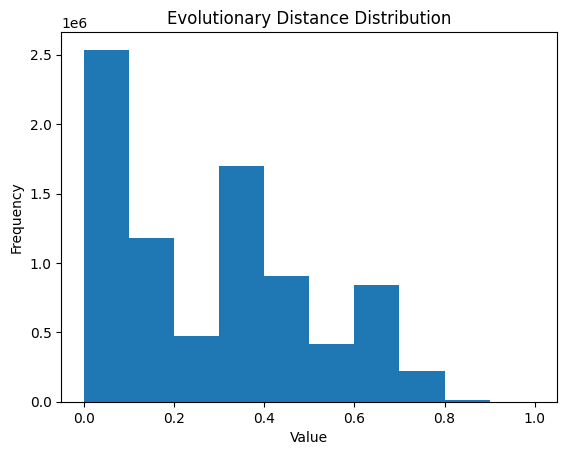

In [6]:
import matplotlib.pyplot as plt

upper_triangular = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
normalized = (upper_triangular - upper_triangular.min()) / (upper_triangular.max() - upper_triangular.min())
print(len(upper_triangular) - len([el for el in upper_triangular if el]))
row_inds, col_inds = np.where(distance_matrix == 0)

inds = [(r, c) for r, c in zip(row_inds, col_inds) if r < c] 
print(f"{len(inds)} pairs with zero distance")
print(inds[0])
plt.hist(normalized)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Evolutionary Distance Distribution")
plt.show()

In [7]:
pd.DataFrame(normalized).describe()


,0
count,8.280415e+06
mean,2.859105e-01
std,2.173672e-01
min,0.000000e+00
25%,8.602151e-02
50%,2.903226e-01
75%,4.301075e-01
max,1.000000e+00


In [8]:
# Save the distance matrix

# Save as numpy array (efficient for loading later)
np.save("../data/ma_evolutionary_distance_matrix.npy", distance_matrix)

np.save(
    "../data/ma_evolutionary_distance_matrix_normalized.npy",
    (distance_matrix - distance_matrix.min())
    / (distance_matrix.max() - distance_matrix.min()),
)

# Save the node names mapping (to know which row/column corresponds to which node)
with open("../data/ma_distance_matrix_node_names.txt", "w") as f:
    for name in ma_node_names:
        f.write(f"{name}\n")